In [ ]:
# import jax
# import jax.numpy as jnp

# jax.config.update("jax_compilation_cache_dir", "./jax-caches")
# jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
# jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../"))

# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.25"
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
# os.environ["XLA_FLAGS"] = (
#     "--xla_disable_hlo_passes=constant_folding"  # this disables constant folding
# )
from desc import set_device
set_device("gpu")

In [2]:
# from desc import set_device, _set_cpu_count

# num_device = 2
# _set_cpu_count(num_device)
# set_device("cpu", num_device=num_device)

In [3]:
import numpy as np
np.set_printoptions(linewidth=np.inf, precision=4, suppress=True, threshold=sys.maxsize)
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import functools
import scipy

In [4]:
import desc

from desc.basis import *
from desc.backend import *
from desc.compute import *
from desc.coils import *
from desc.equilibrium import *
from desc.examples import *
from desc.grid import *
from desc.geometry import *

from desc.objectives import *
from desc.objectives.objective_funs import *
from desc.objectives.getters import *
from desc.objectives.normalization import compute_scaling_factors
from desc.objectives.utils import *
from desc.optimize._constraint_wrappers import *

from desc.transform import Transform
from desc.plotting import *
from desc.optimize import *
from desc.perturbations import *
from desc.profiles import *
from desc.compat import *
from desc.utils import *
from desc.magnetic_fields import *

from desc.__main__ import main
from desc.vmec_utils import vmec_boundary_subspace
from desc.input_reader import InputReader
from desc.continuation import solve_continuation_automatic
from desc.compute.data_index import register_compute_fun
from desc.optimize.utils import solve_triangular_regularized

print_backend_info()

DESC version=0.14.2+719.g9f3f48f80.dirty.
Using JAX backend: jax version=0.6.2, jaxlib version=0.6.2, dtype=float64.
Using device: NVIDIA GeForce RTX 4080 Laptop GPU (id=0), with 11.99 GB available memory.


In [5]:
from diffrax import *
from desc.particles import *
import timeit
from desc.particles import _trace_particles

In [ ]:
eq = get("precise_QA")
surf = eq.get_surface_at(rho=0.3)
grid = LinearGrid(rho=surf.rho, M=eq.M_grid, N=40)
axis = eq.get_axis()
grid_axis = LinearGrid(N=1000, rho=0)

In [ ]:
xyz_curve = eq.compute("x", grid=grid_axis, basis="xyz")["x"]

In [ ]:
model = VacuumGuidingCenterTrajectory(frame="flux")
particles_surf = SurfaceParticleInitializer(surface=surf, N=1000, grid=grid)
x0, args = particles_surf.init_particles(model, eq)
def to_lab(coords):
    grid = Grid(coords, jitable=True)
    return eq.compute("x", grid=grid)["x"]

rpz = vmap(to_lab, in_axes=(0,))(x0[:, :3])
xs = rpz[:, 0, 0] * jnp.cos(rpz[:, 0, 1])
ys = rpz[:, 0, 0] * jnp.sin(rpz[:, 0, 1])
zs = rpz[:, 0, 2]

In [ ]:
particles_curve = CurveParticleInitializer(curve=axis, N=100, grid=grid_axis)
x0, args = particles_curve.init_particles(model, eq)

def to_lab(coords):
    grid = Grid(coords, jitable=True)
    return eq.compute("x", grid=grid)["x"]

rpz_curve = vmap(to_lab, in_axes=(0,))(x0[:, :3])
xc = rpz_curve[:, 0, 0] * jnp.cos(rpz_curve[:, 0, 1])
yc = rpz_curve[:, 0, 0] * jnp.sin(rpz_curve[:, 0, 1])
zc = rpz_curve[:, 0, 2]

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fig = plot_3d(
        surf,
        "|e_theta x e_zeta|",
        showaxislabels=False,
        showgrid=False,
        zeroline=False,
        showticklabels=False,
        cmap="plasma",
        showscale=False,
    )
    fig = plot_3d(
        eq,
        "|e_theta x e_zeta|",
        alpha=0.1,
        fig=fig,
        showaxislabels=False,
        showgrid=False,
        zeroline=False,
        showticklabels=False,
        showscale=False,
        cmap="plasma",
    )
fig.add_trace(
    go.Scatter3d(
        x=xs,
        y=ys,
        z=zs,
        mode="markers",
        marker=dict(size=5, color="black"),
        showlegend=False,
    )
)

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fig = plot_3d(
        eq,
        "|e_theta x e_zeta|",
        alpha=0.1,
        showaxislabels=False,
        showgrid=False,
        zeroline=False,
        showticklabels=False,
        showscale=False,
        cmap="plasma",
    )
fig.add_trace(
    go.Scatter3d(
        x=xyz_curve[:, 0],
        y=xyz_curve[:, 1],
        z=xyz_curve[:, 2],
        mode="lines",
        line=dict(
            color="black",
            width=10,
        ),
        marker=dict(size=0),
        showlegend=False,
    )
)
fig.add_trace(
    go.Scatter3d(
        x=xc,
        y=yc,
        z=zc,
        mode="markers",
        marker=dict(size=5, color="red"),
        showlegend=False,
    )
)

In [ ]:
eqh = get("precise_QH")
particles = ManualParticleInitializerFlux(rho0=0.4, theta0=0, zeta0=0, xi0=0.5, E=1e4)
fig = plot_3d(
    eqh,
    "|B|",
    alpha=0.3,
    showaxislabels=False,
    showgrid=False,
    zeroline=False,
    showticklabels=False,
    showscale=False,
)
plot_particle_trajectories(
    eqh,
    model,
    particles,
    ts=np.linspace(0, 5e-5, 1000),
    fig=fig,
    showaxislabels=False,
    showgrid=False,
    zeroline=False,
    showticklabels=False,
)

(<Figure size 1152.57x960.473 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>, <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>, <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>, <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>, <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>, <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>], dtype=object))

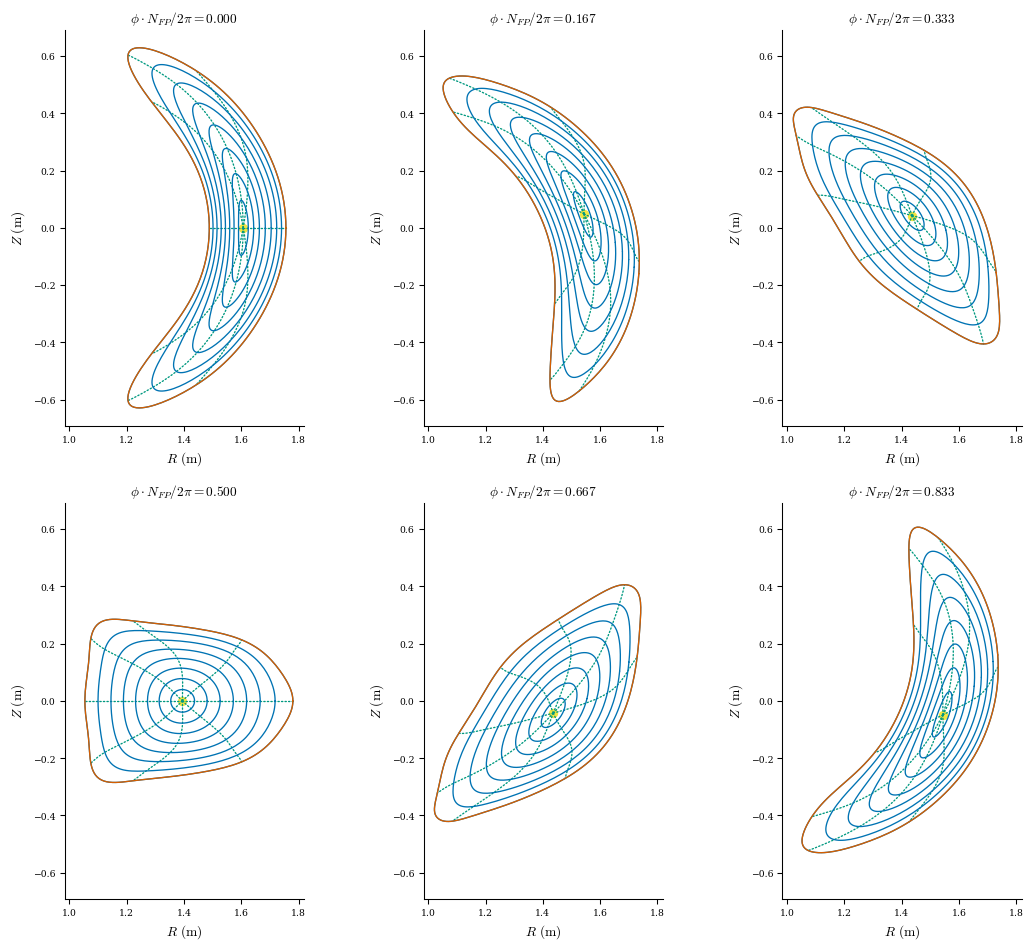

In [79]:
eqn = get("NCSX")
plot_surfaces(eqn);

In [148]:
eqh = get("NCSX")
ids = [0, 1, 4]
xis = np.linspace(0.1, 0.9, 20)[ids]
colors = sequential_colors[0::3]
particles = ManualParticleInitializerFlux(rho0=0.5, theta0=0, zeta0=0, xi0=xis, E=1e4)
model = VacuumGuidingCenterTrajectory(frame="flux")
fig = plot_3d(
    eqh,
    "|B|",
    alpha=0.3,
    showaxislabels=False,
    showgrid=False,
    zeroline=False,
    showticklabels=False,
    showscale=False,
)
fig, data = plot_particle_trajectories(
    eqh,
    model,
    particles,
    ts=np.linspace(0, 2e-4, 1000),
    fig=fig,
    showaxislabels=False,
    showgrid=False,
    zeroline=False,
    showticklabels=False,
    return_data=True,
    color=colors,
)
fig

/CODES/DESC/desc/utils.py:572: UserWarning:

Unequal number of field periods for grid 1 and basis 3.

/CODES/DESC/desc/utils.py:572: UserWarning:

Unequal number of field periods for grid 1 and basis 3.



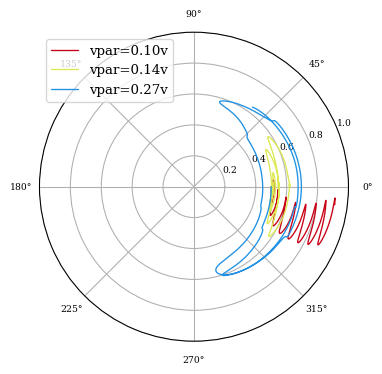

In [164]:
from desc.plotting import colorblind_colors, sequential_colors

for idx in range(len(data["rho"])):
    plt.polar(
        data["theta"][idx],
        data["rho"][idx],
        color=colors[idx % len(colors)],
        label=f"vpar={xis[idx]:.2f}v",
    )
plt.ylim([0, 1])
plt.legend()
plt.savefig("polar-ncsx.png", dpi=500)

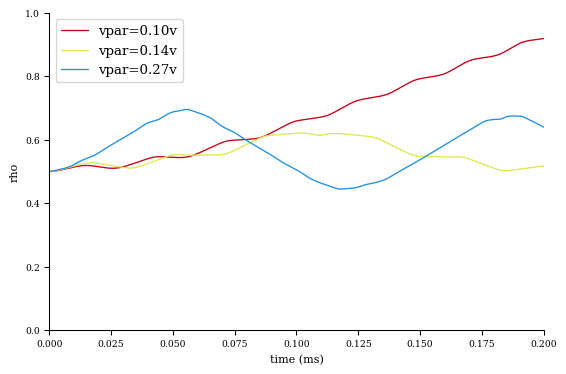

In [165]:
for idx in range(len(data["rho"])):
    plt.plot(
        np.linspace(0, 2e-4, 1000)*1000,
        data["rho"][idx],
        color=colors[idx % len(colors)],
        label=f"vpar={xis[idx]:.2f}v",
    )
plt.ylim([0, 1])
plt.xlim([0, 2e-1])
plt.xlabel("time (ms)")
plt.ylabel("rho")
plt.legend()
plt.savefig("rho-evalution-ncsx.png", dpi=500)